In [1]:
import tensorflow as tf

In [2]:
from tensorflow_examples.models.pix2pix import pix2pix

import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from IPython.display import clear_output
import matplotlib.pyplot as plt

In [3]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

Shuffling and writing examples to /Users/dinesh/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteG9MHG7/oxford_iiit_pet-train.tfrecord
Shuffling and writing examples to /Users/dinesh/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteG9MHG7/oxford_iiit_pet-test.tfrecord
Dataset oxford_iiit_pet downloaded and prepared to /Users/dinesh/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


TypeError: 'PrefetchDataset' object is not subscriptable

In [4]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask

In [21]:
@tf.function
def load_image_train(datapoint):
  print((datapoint))
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  if tf.random.uniform(()) > 0.5:
    input_image = tf.image.flip_left_right(input_image)
    input_mask = tf.image.flip_left_right(input_mask)

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [22]:
def load_image_test(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [23]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [24]:
train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = dataset['test'].map(load_image_test)

{'file_name': <tf.Tensor 'datapoint:0' shape=() dtype=string>, 'image': <tf.Tensor 'datapoint_1:0' shape=(None, None, 3) dtype=uint8>, 'label': <tf.Tensor 'datapoint_2:0' shape=() dtype=int64>, 'segmentation_mask': <tf.Tensor 'datapoint_3:0' shape=(None, None, 1) dtype=uint8>, 'species': <tf.Tensor 'datapoint_4:0' shape=() dtype=int64>}


In [9]:
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

In [10]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

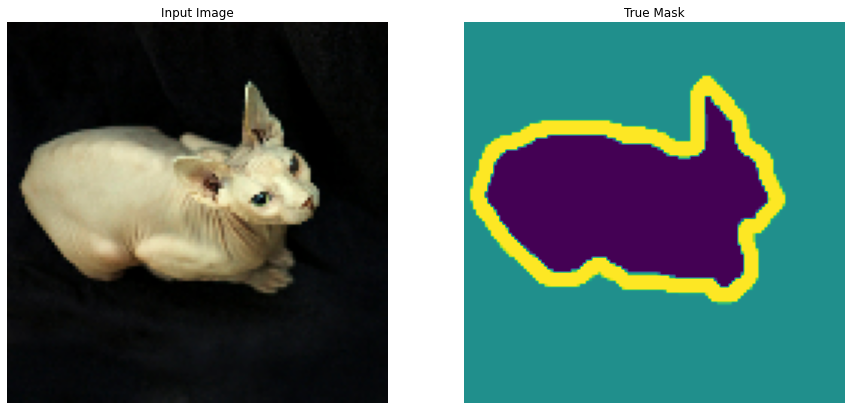

In [11]:
for image, mask in train.take(1):
  sample_image, sample_mask = image, mask
display([sample_image, sample_mask])